In [226]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42)  


In [227]:
layer_num=3
hidden_num=64
sym='symetry'

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)+self.MLP(-x)

In [228]:
def potential(x,k):
    poten=1/2*k*x**2
    return poten

In [229]:
def energy(en_level,k,m,h_bar,device,dtype):
    omega=np.sqrt(k/m)
    en_list=[h_bar*omega*(1/2+i) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [ ]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
para_mult=4
La=-5*para_mult
Lb =5*para_mult
L=Lb-La  # domain length
N = 1500*para_mult   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0

k=4
en_num=50
epoch=3000
lr=0.01
real_en=energy(en_num,k,m,h_bar,device,dtype)

model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=20,threshold=1e-4)
loss_fn=nn.L1Loss()
# Construct the tridiagonal matrix A
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,k)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
print('initial eigenvalues check:')
print(eigenvalues[:en_num])


initial eigenvalues check:
tensor([ 1.0012,  2.9993,  5.0009,  6.9994,  9.0018, 10.9999, 13.0016, 15.0002,
        17.0009, 19.0001, 21.0007, 22.9999, 24.9998, 26.9991, 28.9987, 30.9985,
        32.9983, 34.9974, 36.9979, 38.9943, 40.9964, 42.9975, 44.9946, 46.9946,
        48.9931, 50.9955, 52.9927, 54.9906, 56.9935, 58.9904, 60.9900, 62.9900,
        64.9895, 66.9884, 68.9876, 70.9872, 72.9857, 74.9851, 76.9847, 78.9834,
        80.9825, 82.9821, 84.9807, 86.9794, 88.9787, 90.9739, 92.9781, 94.9775,
        96.9747, 98.9736], device='cuda:0')


In [231]:

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    '''output=NN(input)
    diag=torch.diag(output.flatten())'''
    
    print('\nepoch:',i)
    print(eigenvalues[:en_num])
    print(real_en)
    
    output=eigenvalues[:en_num]
    loss=loss_fn(output,real_en)
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}/model_para_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}/model_para_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')



epoch: 0
tensor([-0.1628, -0.1555, -0.1290, -0.0825, -0.0645,  0.0117,  0.0584,  0.0869,
         0.1634,  0.2249,  0.2617,  0.3503,  0.4298,  0.5100,  0.5963,  0.6908,
         0.7917,  0.9009,  1.0162,  1.1351,  1.2618,  1.3953,  1.5328,  1.6778,
         1.8309,  1.9911,  2.1451,  2.3166,  2.4934,  2.6749,  2.8614,  3.0582,
         3.2589,  3.4669,  3.6785,  3.8955,  4.1206,  4.3524,  4.5901,  4.8353,
         5.0848,  5.3409,  5.6020,  5.8688,  6.1453,  6.4272,  6.7133,  7.0049,
         7.3034,  7.6084], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25., 27.,
        29., 31., 33., 35., 37., 39., 41., 43., 45., 47., 49., 51., 53., 55.,
        57., 59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.,
        85., 87., 89., 91., 93., 95., 97., 99.], device='cuda:0')
epoch:0,loss:47.45659255981445,time:0.30083703994750977,lr:0.01

epoch: 1
tensor([ 1.2376,  1.8574,  2.4078,  2.9084,  3.3762,  3.8102,  4.2

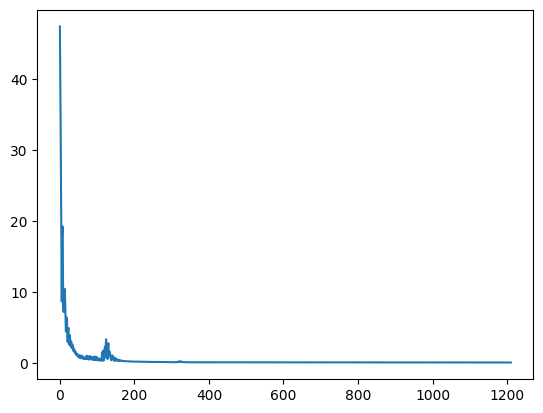

In [232]:
plt.plot(loss_list)
plt.show()

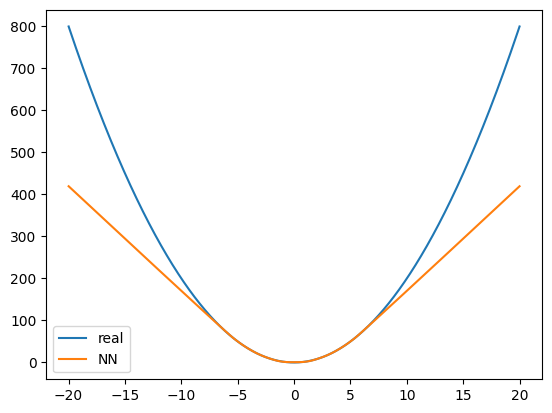

In [233]:

V_NN=model(grid)

os.makedirs(f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
torch.save(V_NN,f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}/V_NN_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')

V_NN=V_NN.cpu().detach().numpy()
real_poten=potential(grid.cpu().detach().numpy(),k)
plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.plot(grid.cpu().detach().numpy(),V_NN,label='NN')
plt.legend()
plt.show()

In [234]:
error=V_NN-real_poten
mean_error=np.mean(np.abs(error))
max_error=np.max(np.abs(error))
print('mean_error:',mean_error)
print('max_error:',max_error)

mean_error: 87.824
max_error: 380.15347
